In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from tqdm.notebook import tqdm
import os
from pathlib import Path

import torch
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [2]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        

from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict

# Test Dataset Images

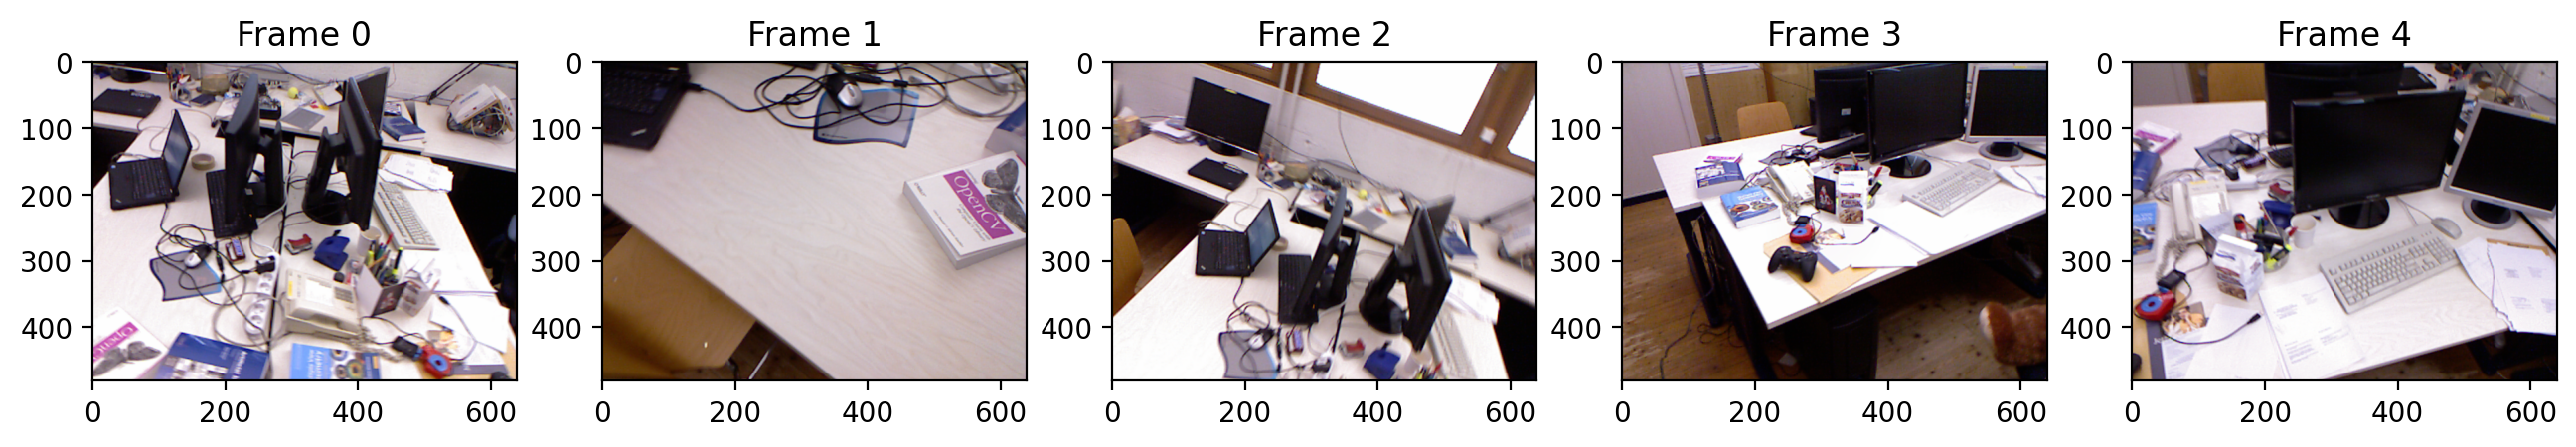

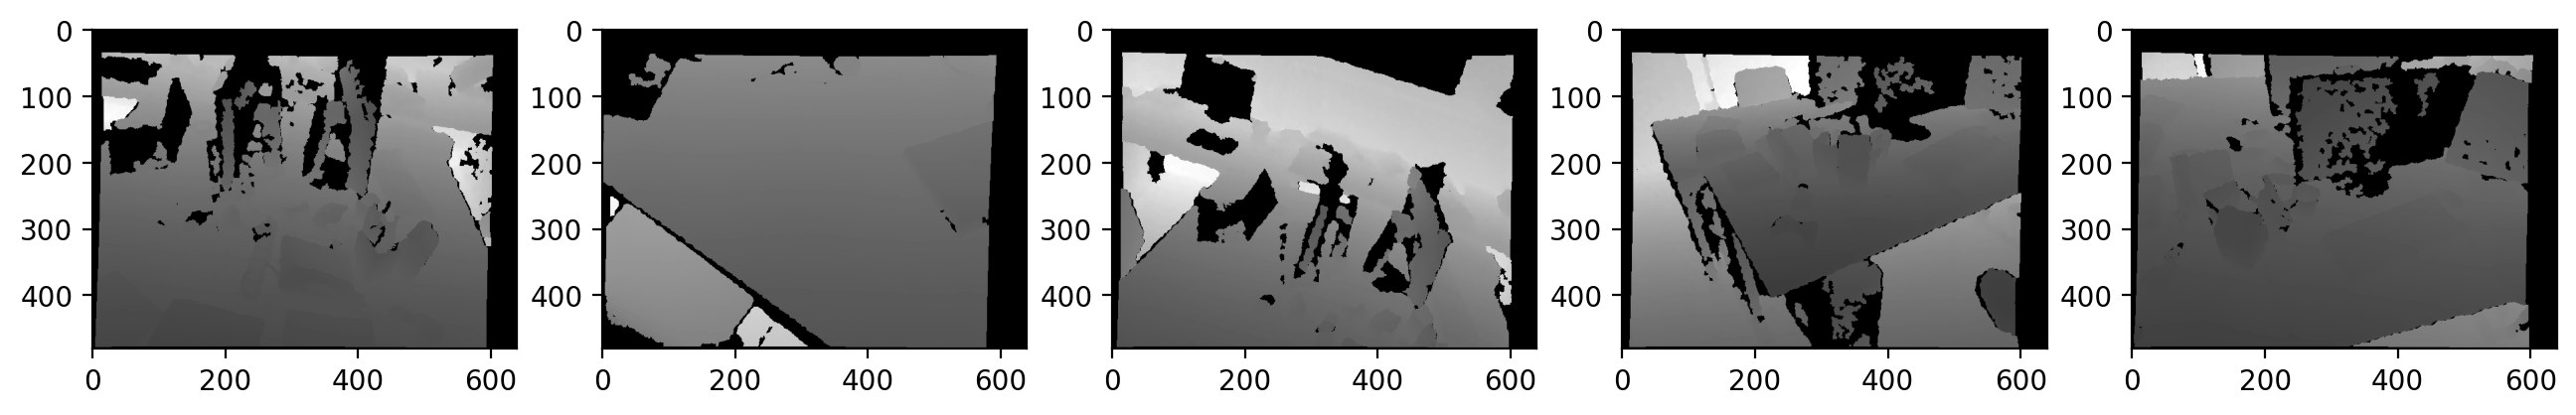

In [3]:
frames = [0, 2]
test_images_list = [
"1305031458.159638.png", "1305031462.692548.png", "1305031464.959763.png","1305031467.695886.png",  "1305031469.296754.png"
]
test_depthes_list = [
    "1305031458.144808.png", "1305031462.680788.png", "1305031464.952471.png", "1305031467.686044.png", "1305031469.288263.png"
]

figure = plt.figure(dpi=200, figsize=(16,10))

for i in range(len(test_images_list)):
    
    color_image_path = str(Path(f"../test/datasets/tum rgbd/rgbd_dataset_freiburg1_desk/rgb/{test_images_list[i]}"))
    color_image = cv2.imread(color_image_path)
    plt.subplot(1,5,i+1)
    plt.title(f'Frame {i}')
    plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))


    
figure = plt.figure(dpi=200, figsize=(16,10))
factor = 5000 # for the 16-bit PNG files
# OR: factor = 1 # for the 32-bit float images in the ROS bag files
for i in range(len(test_images_list)):
    
    depth_image_path = str(Path(f"../test/datasets/tum rgbd/rgbd_dataset_freiburg1_desk/depth/{test_depthes_list[i]}"))
    depth_image = cv2.imread(depth_image_path, -1).astype(np.float32) / factor
    depth_image = np.clip(depth_image, 0, 4)
    plt.subplot(1,5,1+i)
    plt.imshow(depth_image, cmap="gray")
    

# Create Dataset Loader

In [4]:
from imap.data.datasets.tum.tum_dataset_loader_factory import TUMDatasetLoaderFactory
from imap.model.input.model_buffer_input import ModelBufferInput
from imap.model.primitives import State, Frame

In [5]:
dataset_params = {'dataset_path': "../test/datasets/tum rgbd/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [131, 257, 325, 407, 455],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading ../test/datasets/tum rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt


# Create Model

In [39]:
from imap.model.nerf import NERF
from imap.model.embeddings.gaussian_positional_encoding import GaussianPositionalEncoding

In [40]:
model_parameters = AttributeDict(
    name="NERF",
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    minimal_depth=0.01,
    positional_embedding = AttributeDict(
                                        name = 'GaussianPositionalEncoding',
                                        encoding_dimension=92,
                                        sigma=25,
                                        use_only_sin=True
                                        )
)

factory = UniversalFactory([NERF, GaussianPositionalEncoding])
model = factory.make_from_parameters(model_parameters, camera_info=camera)

# Train the Model

In [41]:
from imap.trainers.trainers import ModelTrainer

In [42]:
model = model.to('cuda')
model.train()
trainer = ModelTrainer(model, lr=0.01)
num_epochs = 300
points_per_image = int(640 * 480 / 100)


model_buffer_input = ModelBufferInput(points_per_frame=points_per_image)

for i in tqdm(range(num_epochs)):
    # update model input buffer
    for color_image, depth_image, position in dataset_loader:
        color_image = camera.process_color_image(color_image)
        depth_image = camera.process_depth_image(depth_image)[0]
        position = camera.process_positions(position)
        
        frame = Frame(color_image, depth_image)
        state = State(frame, position)
        model_buffer_input.update_data(state)

    # train the model
    for batch in model_buffer_input:
        loss = trainer.train(model, batch)
    # trainer.reset_params()
    
    if i%5 == 0:
        print(f"loss {loss}")
    # clear_output(wait=True)
    
torch.cuda.empty_cache()

  0%|          | 0/300 [00:00<?, ?it/s]

loss 2.033557176589966
loss 1.579931616783142
loss 1.1403589248657227
loss 1.0167467594146729
loss 0.9168628454208374
loss 0.9582399725914001
loss 0.875769853591919
loss 0.8561429381370544
loss 0.8311207294464111
loss 0.8174022436141968
loss 0.8716205358505249
loss 0.7606208324432373
loss 0.8324305415153503
loss 0.8006352782249451
loss 0.7530216574668884
loss 0.8281509280204773
loss 0.8093023300170898
loss 0.7010228037834167
loss 0.7486163973808289
loss 0.688360869884491
loss 0.8005387783050537
loss 0.7374126315116882
loss 0.7083780169487
loss 0.7724738121032715
loss 0.6643177270889282
loss 0.6853055357933044
loss 0.6308656334877014
loss 0.6442222595214844
loss 0.6318576335906982
loss 0.6564840078353882
loss 0.625249981880188
loss 0.6326532363891602
loss 0.701898455619812
loss 0.646507203578949
loss 0.5867981910705566
loss 0.6217867136001587
loss 0.6468062996864319
loss 0.6256346106529236
loss 0.6278679966926575
loss 0.6343306303024292
loss 0.5840113162994385
loss 0.6336427927017212
lo

# Show the results

In [43]:
from imap.utils.utils import *

In [44]:
# prepare image coordinates

scale = 1
height = color_image.shape[0]
width = color_image.shape[1]
x, y = generate_image_meshgrid(height, width, scale)
np_pixels = get_pixels_from_meshgrid(x, y, scale)


In [45]:
# positions for rendering
positions = []
for _, _, position in dataset_loader:
    color_image = camera.process_color_image(color_image)
    depth_image = camera.process_depth_image(depth_image)[0]
    positions.append(camera.process_positions(position).T)

In [46]:
# reder the image

batch_size = 4096

model = model.cuda()
model.eval()


pixels = torch.from_numpy(np_pixels).cuda()

color_coarse_images = []
depth_coarse_images =[]
color_fine_images = []
depth_fine_images = []

mean = camera._color_mean
std = camera._color_std

with torch.no_grad():
    for pos in positions:
        
        position = torch.from_numpy(pos).to('cuda')
        output_coarse_color = []
        output_coarse_depth = []
        output_fine_color = []
        output_fine_depth = []

        for i in tqdm(range(pixels.shape[0] // batch_size)):
            output = model(pixels[i * batch_size:i * batch_size + batch_size],
                                 position)
            output_coarse_color.append(output[0])
            output_coarse_depth.append(output[1])
            output_fine_color.append(output[2])
            output_fine_depth.append(output[3])

        reconstructed_image = torch.cat(output_coarse_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
        reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
        reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
        color_coarse_images.append(reconstructed_image)
        
        reconstructed_image = torch.cat(output_fine_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
        reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
        reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
        color_fine_images.append(reconstructed_image)
        
        reconstructed_depth = torch.cat(output_coarse_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
        depth_coarse_images.append(reconstructed_depth)
        
        
        reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
        depth_fine_images.append(reconstructed_depth)

del output_coarse_color, output_coarse_depth, output_fine_color, output_fine_depth, position, pixels
torch.cuda.empty_cache()

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

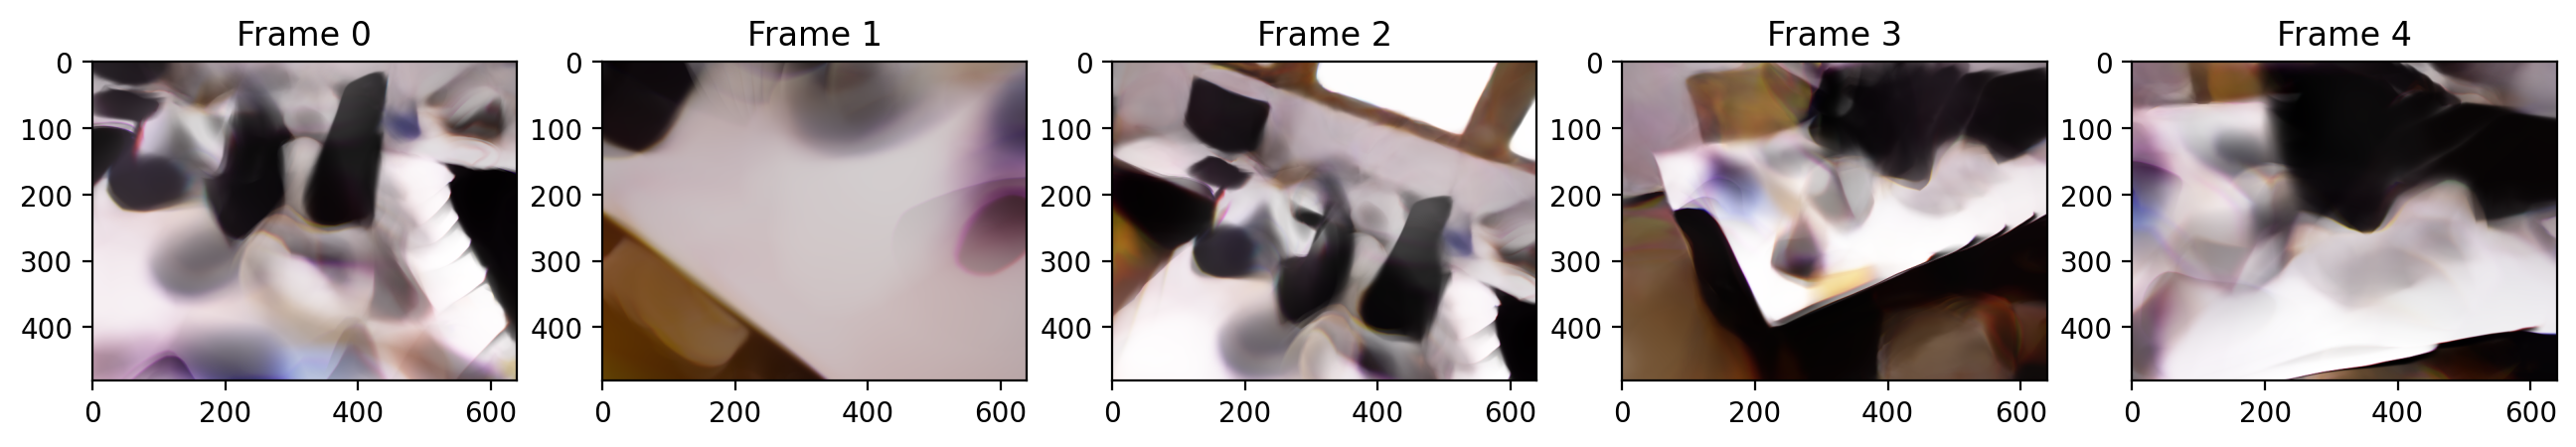

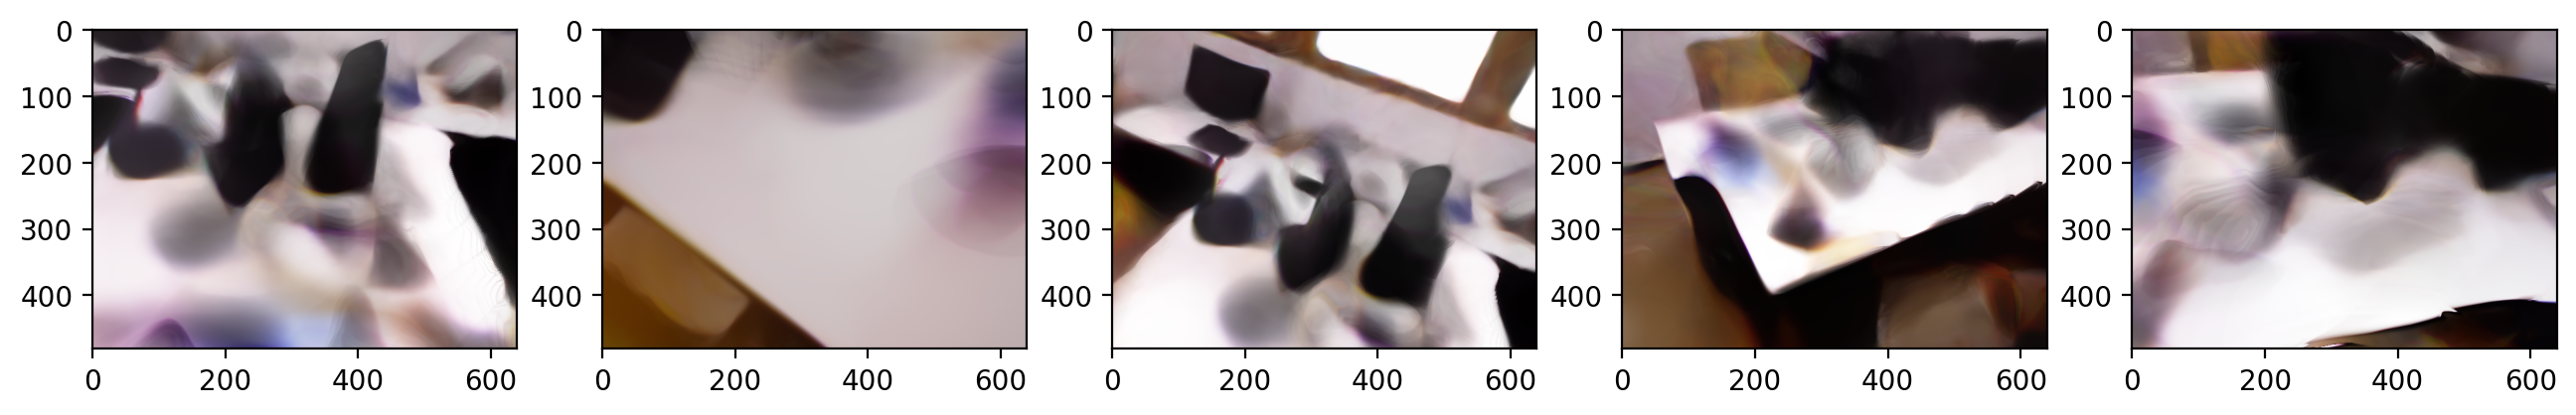

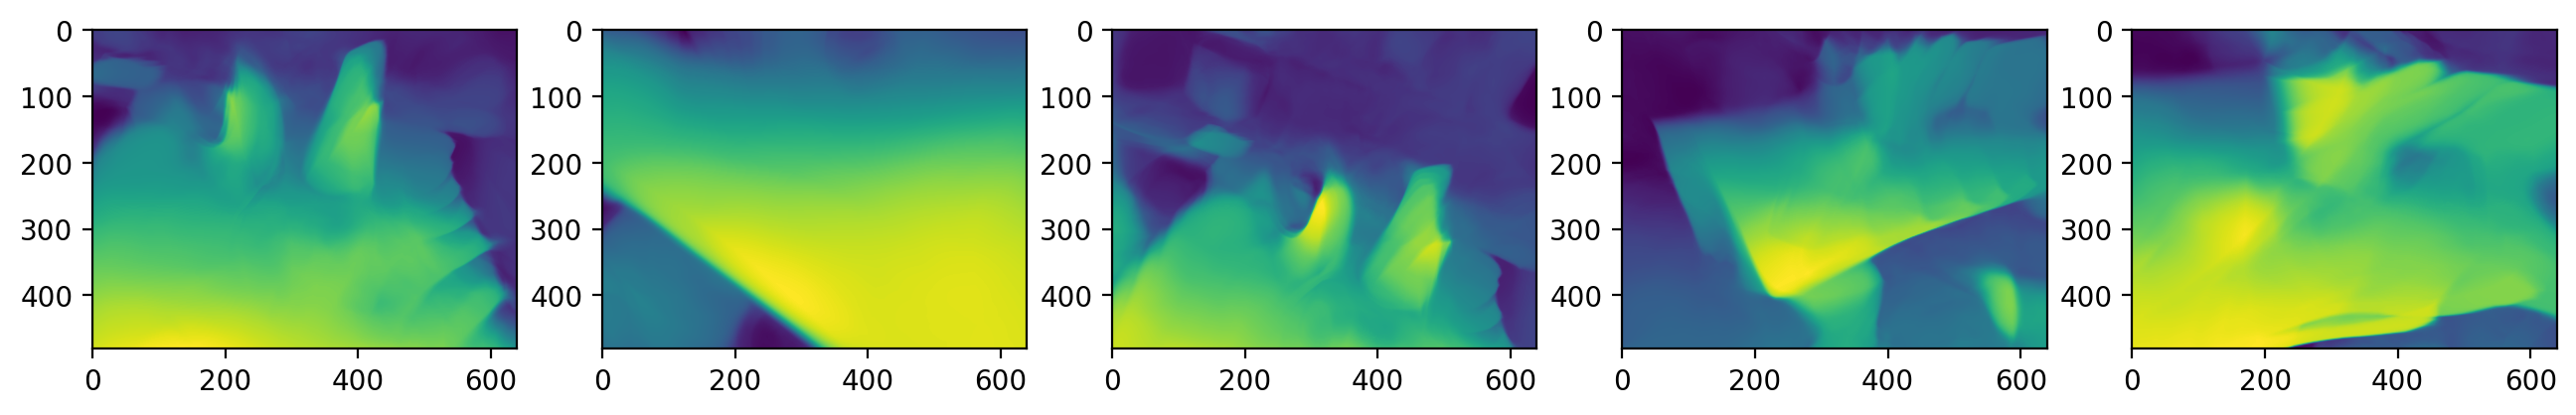

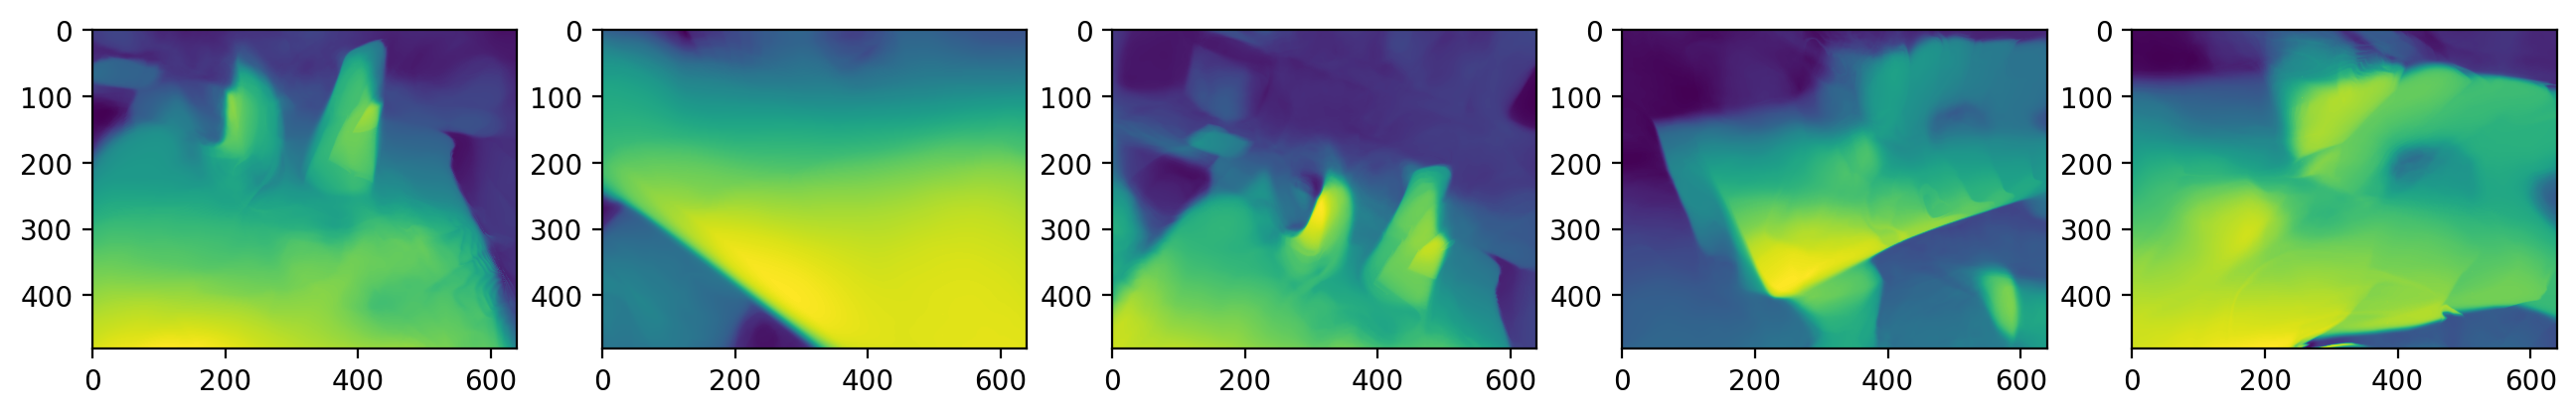

In [47]:
figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(len(positions)):
    plt.subplot(1,len(positions),i+1)
    plt.title(f'Frame {i}')
    plt.imshow(cv2.cvtColor(color_coarse_images[i], cv2.COLOR_RGB2BGR))

figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(len(positions)):
    plt.subplot(1,len(positions),i+1)
    plt.imshow(cv2.cvtColor(color_fine_images[i], cv2.COLOR_RGB2BGR))

figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(len(positions)):
    plt.subplot(1,len(positions),i+1)
    plt.imshow(1. /depth_coarse_images[i])


figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(len(positions)):
    plt.subplot(1,len(positions),i+1)
    plt.imshow(1. /depth_fine_images[i])

# Test depth sampling

In [15]:
batch = None
for x in data_module.train_dataloader():
    batch = x
    break

NameError: name 'data_module' is not defined

In [24]:
image_index = 0
y = 304
x = 300
dataset_index = image_index * 480 * 640 + y * 640 + x
element = data_module._dataset[dataset_index]
pixel = torch.tensor(element['pixel']).cuda()[None]
camera_position = torch.tensor(element['camera_position']).cuda()[None]
truth_depth = torch.tensor(element['depth']).cuda()[None]

In [25]:
# pixel = batch['pixel'].cuda()
# camera_position = batch['camera_position'].cuda()
# truth_depth = batch['depth'].cuda()
course_sampled_depths = model.stratified_sample_depths(
    pixel.shape[0],
    pixel.device,
    model.hparams.course_sample_bins,
    False)
model = model.cuda()

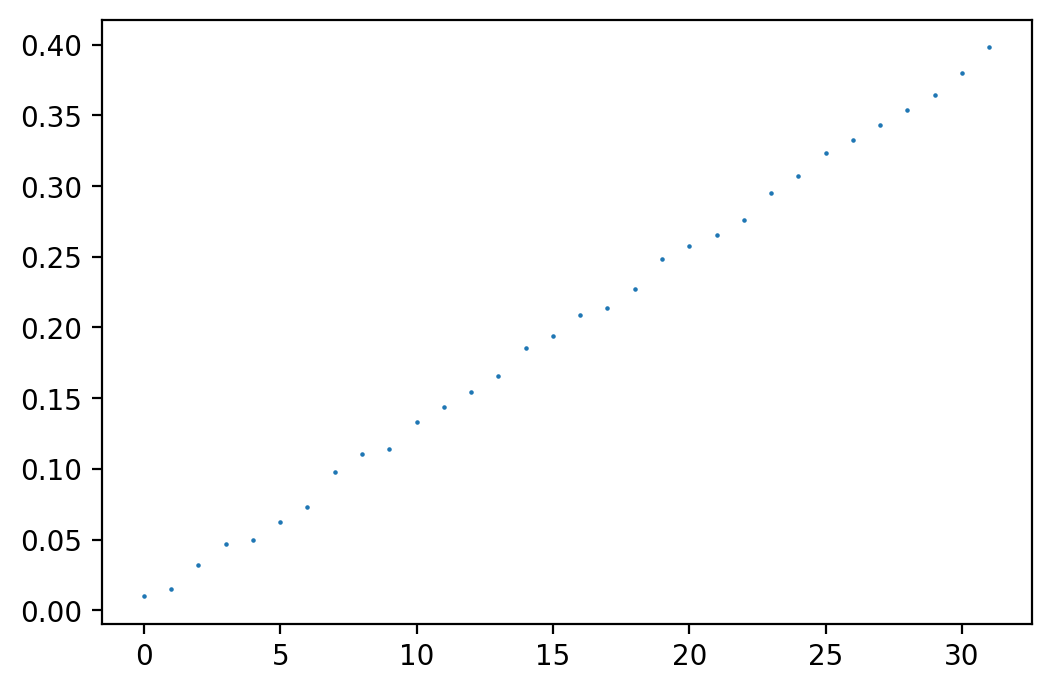

In [26]:
plt.figure(dpi=200)
plotted_depths = course_sampled_depths[:, 0].detach().cpu().numpy()
plt.scatter(np.arange(plotted_depths.shape[0]), plotted_depths, s=0.4)

In [27]:
course_color, course_depths, course_weights, course_depth_variance = model.reconstruct_color_and_depths(
    course_sampled_depths,
    pixel,
    camera_position,
    model._mlp)

In [28]:
bins_count = course_sampled_depths.shape[0]
sampled_depths = torch.sort(course_sampled_depths, dim=0).values
sampled_depths = course_sampled_depths.reshape(-1)
pixels1 = model.repeat_tensor(pixel, bins_count)
camera_positions1 = model.repeat_tensor(camera_position, bins_count)
back_projected_points = back_project_pixel(pixels1, sampled_depths, camera_positions1,
                                           model._inverted_camera_matrix)
encodings = model._positional_encoding(back_projected_points)
prediction = model._mlp(encodings)

colors = prediction[:, :3].reshape(bins_count, -1, 3)
density = prediction[:, 3].reshape(bins_count, -1)

logsumexp_density = torch.logsumexp(torch.cat([torch.zeros_like(density)[None], density[None]], dim=0), dim=0)

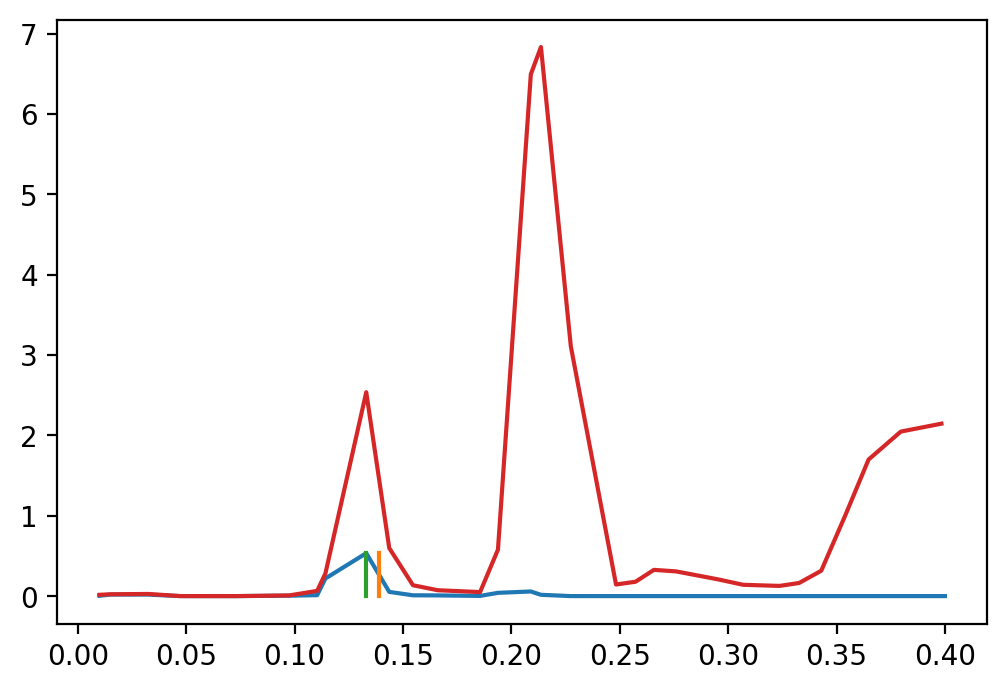

In [29]:
plt.figure(dpi=200)
index = 0
plotted_depths = course_sampled_depths[:, index].detach().cpu().numpy()
plotted_depths = np.append(plotted_depths, 0.4)
plotted_weigths = course_weights[:, index].detach().cpu().numpy()
plotted_truth_depth = truth_depth[index].detach().cpu().numpy()
plotted_density = logsumexp_density[:, index].detach().cpu().numpy()
mean_depth = np.sum(plotted_depths * plotted_weigths)
plt.plot(plotted_depths, plotted_weigths)
plt.plot([plotted_truth_depth, plotted_truth_depth], [0, np.max(plotted_weigths)])
plt.plot([mean_depth, mean_depth], [0, np.max(plotted_weigths)])
plt.plot(plotted_depths[:-1], plotted_density / 50.)

In [30]:
fine_sampled_depths = model.hierarchical_sample_depths(
    course_weights,
    pixel.shape[0],
    pixel.device,
    50,
    course_sampled_depths,
    False)

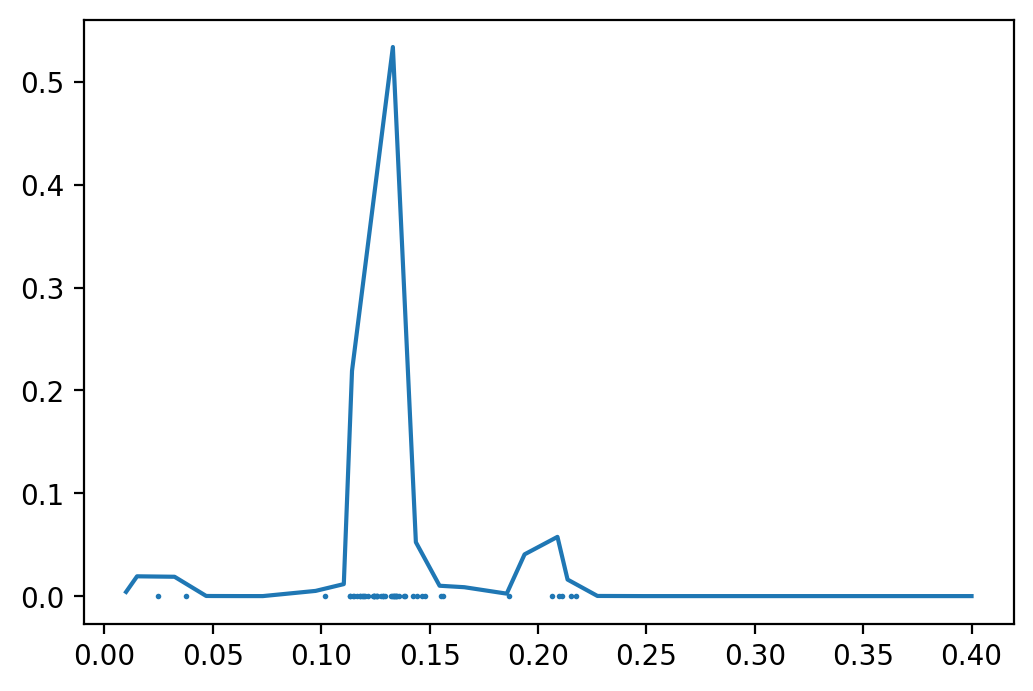

In [31]:
plt.figure(dpi=200)
index = 0
plotted_course_depths = course_sampled_depths[:, index].detach().cpu().numpy()
plotted_course_depths = np.append(plotted_course_depths, 0.4)
plotted_fine_depths = fine_sampled_depths[:, index].detach().cpu().numpy()
plotted_weigths = course_weights[:, index].detach().cpu().numpy()
plt.plot(plotted_course_depths, plotted_weigths)
plt.scatter(plotted_fine_depths, np.zeros_like(plotted_fine_depths), s=1)

In [32]:
with torch.no_grad():
    fine_color, fine_depths, fine_weights, fine_depth_variance = model.reconstruct_color_and_depths(
        fine_sampled_depths,
        pixel,
        camera_position,
        model._mlp)

In [33]:
bins_count = fine_sampled_depths.shape[0]
sampled_depths = torch.sort(fine_sampled_depths, dim=0).values
sampled_depths = fine_sampled_depths.reshape(-1)
pixels1 = model.repeat_tensor(pixel, bins_count)
camera_positions1 = model.repeat_tensor(camera_position, bins_count)
back_projected_points = back_project_pixel(pixels1, sampled_depths, camera_positions1,
                                           model._inverted_camera_matrix)
encodings = model._positional_encoding(back_projected_points)
prediction = model._mlp(encodings)

colors = prediction[:, :3].reshape(bins_count, -1, 3)
density = prediction[:, 3].reshape(bins_count, -1)

fine_logsumexp_density = torch.logsumexp(torch.cat([torch.zeros_like(density)[None], density[None]], dim=0), dim=0)

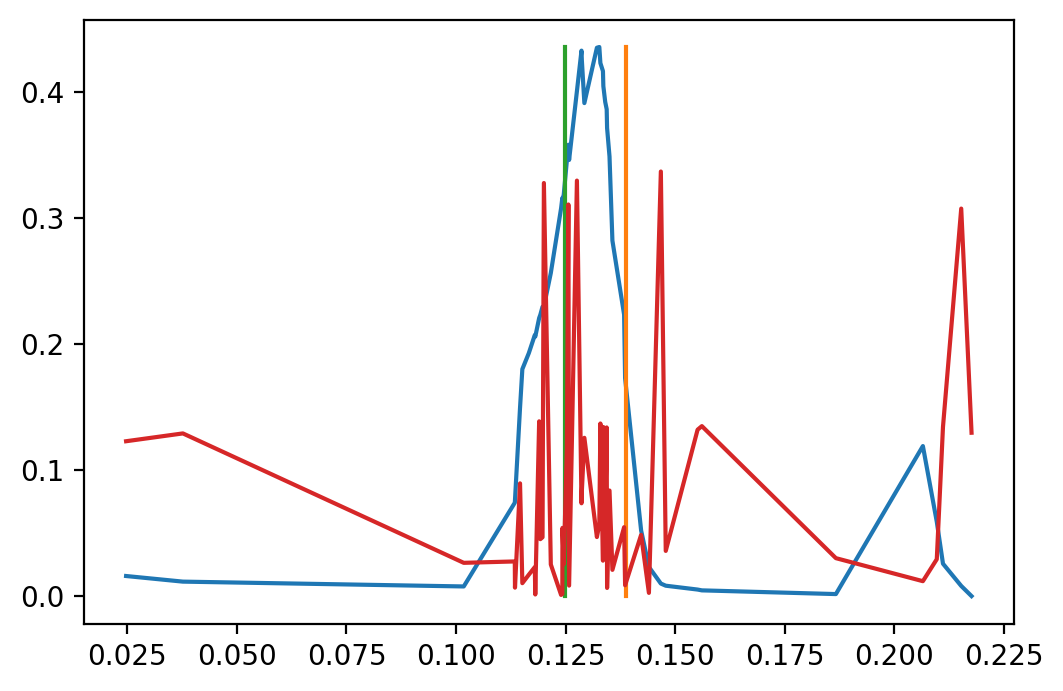

In [34]:
plt.figure(dpi=200)
index = 0
plotted_depths = torch.sort(fine_sampled_depths[:, index], dim=0).values.detach().cpu().numpy()
depth_deltas =  np.roll(plotted_depths, -1) - plotted_depths
plotted_weigths = fine_weights[:, index].detach().cpu().numpy()[:-1]
plotted_truth_depth = truth_depth[index].detach().cpu().numpy()
mean_depth = np.sum(plotted_depths * plotted_weigths)

plt.plot(plotted_depths, plotted_weigths / depth_deltas / 100)

plt.plot([plotted_truth_depth, plotted_truth_depth], [0, np.max(plotted_weigths / depth_deltas / 100)])
plt.plot([mean_depth, mean_depth], [0, np.max(plotted_weigths / depth_deltas / 100)])

plotted_density = fine_logsumexp_density[:, index].detach().cpu().numpy()
plt.plot(plotted_depths, plotted_density / 1000)